# Before running code, load and activate environment.yml

### Step 1. Create an environments directory and tell conda to use it:

    cd ~
    mkdir envs

    [ -f .condarc ] || echo "" > .condarc

    echo "envs_dirs:" >> .condarc
    echo " - ~/envs" >> .condarc

### Step 2. Create your environment, activate the environment, register it with jupyter:

    mamba env create -f environment.yml
    conda activate off_track
    python -m ipykernel install --user --name=off_track

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pointCollection as pc
import os
import h5py
import sparseqr
import LSsurf

plt.rcParams['animation.ffmpeg_path'] = os.path.join(os.environ['CONDA_PREFIX'],'bin','ffmpeg')

# Load Data

In [2]:
datafile = '/home/jovyan/shared-public/off_track/michael/ATL11/n_grn/n_grn_merged_ATL11.h5'
D = pc.data().from_h5(datafile, group='/')
print(D)
print('Lat0: ' + str(D.latitude[0]))
print('Lon0: ' + str(D.longitude[0]))

<class 'pointCollection.data.data'> with shape (149310,),
with fields:
['cycle_number', 'delta_time', 'dem_h', 'fit_quality', 'h_corr', 'h_corr_sigma', 'h_corr_sigma_systematic', 'latitude', 'longitude', 'quality_summary', 'ref_pt', 'x', 'x_atc', 'y']
Lat0: 78.15940165098804
Lon0: -70.17445378972863


# Determine spatial and temporal span and center of data

In [3]:
# Compute span and center of x and y coordinates to be used later to determine span and center of reconstructed grid.
x_max = D.x.max()
x_min = D.x.min()
x_cen = (x_min + x_max)/2
x_span = x_max - x_min
y_max = D.y.max()
y_min = D.y.min()
y_cen = (y_min + y_max)/2
y_span = y_max - y_min

print('Span x: ' + str(x_span))
print('Center x: ' + str(x_cen))
print('Span y: ' + str(y_span))
print('Center y: ' + str(y_cen))

# Convert t from seconds since 1 Jan 2018 to decimal years 
D.assign(t = 2018.0 + D.delta_time/(365.25*86400))

# Compute span and center of t
t_min = np.nanmin(D.t)
t_max = np.nanmax(D.t)
t_cen = round(4*(t_min + t_max)/2)/4
t_span = t_max - t_min
print('Span t: ' + str(t_span))
print('Center t: ' + str(t_cen))

# Populate z, sigma fields used by LSurf with corresponding fields in input data.
D.assign(z = np.copy(D.h_corr))
D.assign(sigma = np.copy(D.h_corr_sigma))

Span x: 19994.707636107574
Center x: -543501.7622474495
Span y: 19993.112764325924
Center y: -1174799.8683875024
Span t: 5.063165838877694
Center t: 2021.75


<class 'pointCollection.data.data'> with shape (149310,),
with fields:
['cycle_number', 'delta_time', 'dem_h', 'fit_quality', 'h_corr', 'h_corr_sigma', 'h_corr_sigma_systematic', 'latitude', 'longitude', 'quality_summary', 'ref_pt', 'x', 'x_atc', 'y', 't', 'z', 'sigma']

# Plot input measurements

Text(0, 0.5, 'Y (m)')

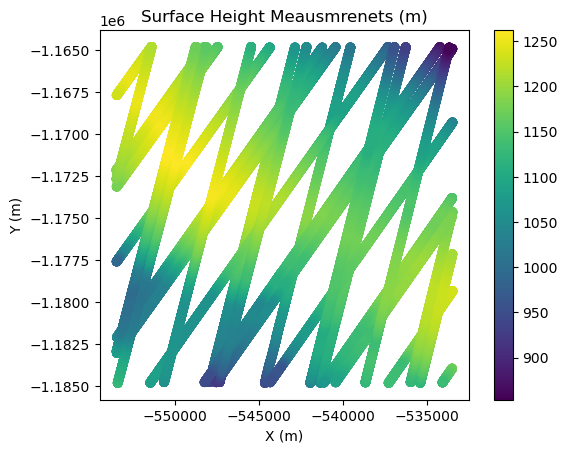

In [5]:
plt.figure()
plt.scatter(D.x, D.y, c=D.z)
plt.gca().set_aspect(1)
plt.colorbar()
plt.title('Surface Height Meausmrenets (m)')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

# Set up LSurf Optimization

In [7]:
from LSsurf.smooth_fit import smooth_fit

E_d3zdx2dt=0.00001 # d/dt of the el diff map curvature. Default = 0.02
E_d2z0dx2=0.06 # 2nd diff of base el map.  Default = 0.00005
E_d2zdt2=5000 # Second time deriv of el diff.  Default = 200000

data=D.copy()
print(data)

ctr={'x':x_cen,'y':y_cen,'t':t_cen} # Data center
print(ctr)
# Width of data in x, y, t
W={'x':2e4,'y':2e4,'t':6} # Numbers should span whats in data. Units don't matter. I use round numbers that are larger than actual spans
print(W)
spacing={'z0':100, 'dz':500, 'dt':0.25} # z0 is elevation spacing, dz is el. diff spacing, dt is temporal spacing between el. diff surfaces.
# Default (ATL14/15).  z0 = 100, dz = 1000.  dt = 0.25.

data_gap_scale=2500
E_RMS={'d2z0_dx2':E_d2z0dx2, 'dz0_dx':E_d2z0dx2*data_gap_scale, 'd3z_dx2dt':E_d3zdx2dt, 'd2z_dxdt':E_d3zdx2dt*data_gap_scale,  'd2z_dt2':E_d2zdt2}
max_iterations = 5

<class 'pointCollection.data.data'> with shape (149310,),
with fields:
['cycle_number', 'delta_time', 'dem_h', 'fit_quality', 'h_corr', 'h_corr_sigma', 'h_corr_sigma_systematic', 'latitude', 'longitude', 'quality_summary', 'ref_pt', 'x', 'x_atc', 'y', 't', 'z', 'sigma']
{'x': -543501.7622474495, 'y': -1174799.8683875024, 't': 2021.75}
{'x': 20000.0, 'y': 20000.0, 't': 6}


# Run LSurf Optimization

In [8]:
# run the fit
S=smooth_fit(data=data, ctr=ctr, W=W, spacing=spacing, E_RMS=E_RMS,
             reference_epoch=5, compute_E=False,
             max_iterations=max_iterations,
             VERBOSE=True, dzdt_lags=[1])

dz=S['m']['dz']
z0=S['m']['z0']
dz.t=dz.time
dz.cell_area=np.tile(dz.cell_area[:,:,None], [1,1, len(dz.t)])

smooth_fit: E_RMS={'d2z0_dx2': 0.06, 'dz0_dx': 150.0, 'd3z_dx2dt': 1e-05, 'd2z_dxdt': 0.025, 'd2z_dt2': 5000}
initial: 94376:
starting qr solve for iteration 0 at Thu Aug 22 20:58:28 2024
found 90672 in TSE, dt=100
	 median(sigma_extra)=0.1044
starting qr solve for iteration 1 at Thu Aug 22 21:00:08 2024
found 89417 in TSE, dt=105
	 median(sigma_extra)=0.0917
starting qr solve for iteration 2 at Thu Aug 22 21:01:53 2024
found 88551 in TSE, dt= 90
	 median(sigma_extra)=0.0864
starting qr solve for iteration 3 at Thu Aug 22 21:03:23 2024
found 87838 in TSE, dt=106
	 median(sigma_extra)=0.0832
starting qr solve for iteration 4 at Thu Aug 22 21:05:09 2024


# Visualize Results

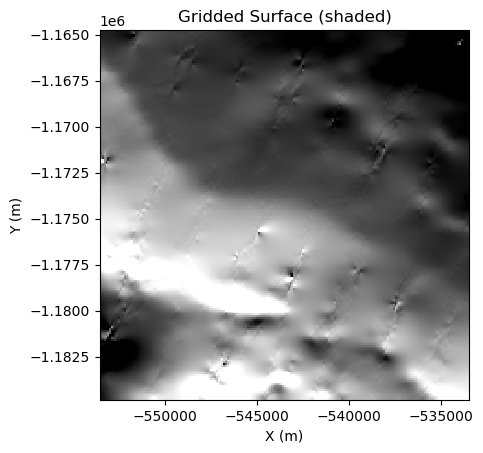

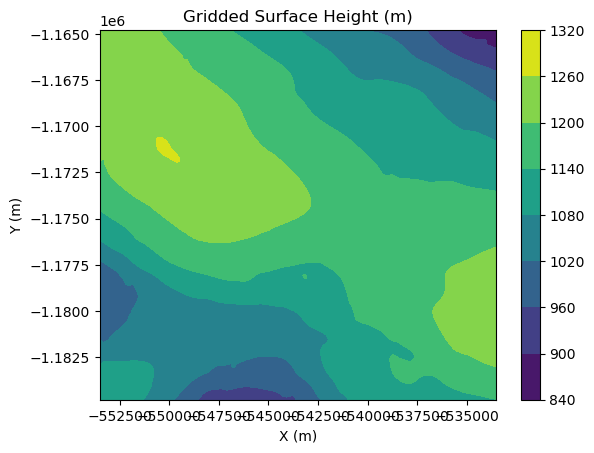

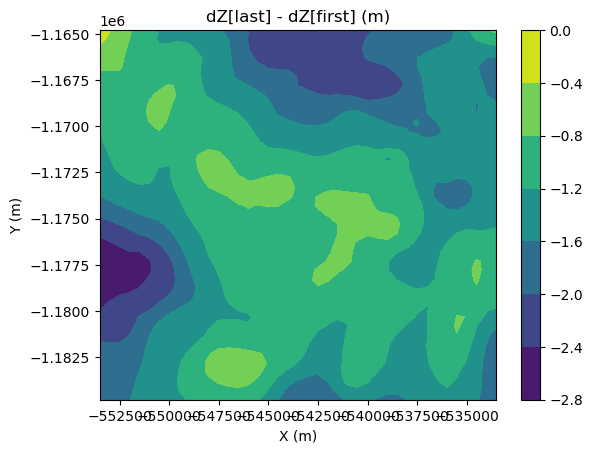

In [65]:
z0.show(gradient=True, field='z0', origin='lower', extent = z0.extent)
plt.title('Gridded Surface (shaded)')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.show()

x0, y0 = np.meshgrid(z0.x, z0.y)
plt.contourf(x0, y0, z0.z0[:,:], origin='lower', extent = dz.extent)
plt.colorbar()
plt.title('Gridded Surface Height (m)')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.show()

xd, yd = np.meshgrid(dz.x, dz.y)
plt.contourf(xd, yd, dz.dz[:,:,-1]-dz.dz[:,:,0], origin='lower', extent = dz.extent)
plt.colorbar()
plt.title('dZ[last] - dZ[first] (m)')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.show()

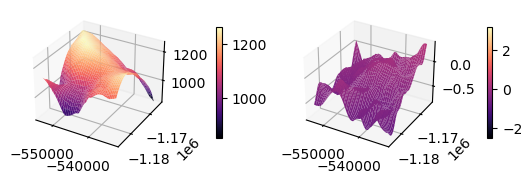

In [101]:
fig, ax = plt.subplots(1, 2, subplot_kw={"projection": "3d"})
plt.figure(fig, figsize=(14,7))
xg0, yg0=np.meshgrid(z0.x, z0.y)
zmin = np.nanmin(z0.z0)
zmax = np.nanmax(z0.z0)
hs=ax[0].plot_surface(xg0, yg0, z0.z0, vmin=zmin, vmax=zmax, cmap='magma')
plt.colorbar(hs, location='right', pad=0.2, shrink=0.3)

xgd, ygd=np.meshgrid(dz.x, dz.y)
dzmin = np.nanmin(dz.dz)
dzmax = np.nanmax(dz.dz)
hs1=ax[1].plot_surface(xgd, ygd, dz.dz[:,:,10], vmin=dzmin, vmax=dzmax, cmap='magma')
plt.colorbar(hs1, location='right', pad=0.2, shrink=0.3)

# Elevation Change Progression

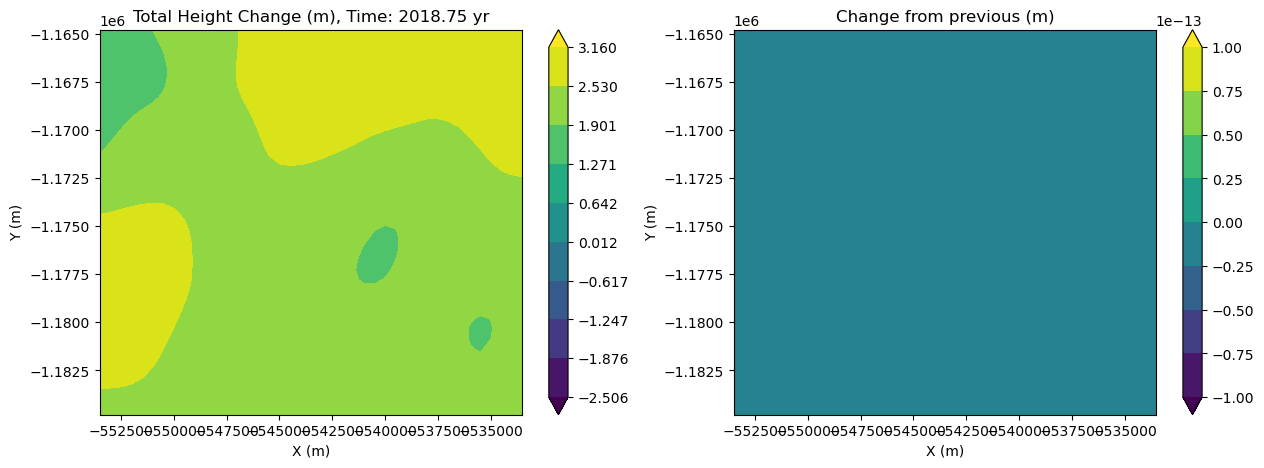

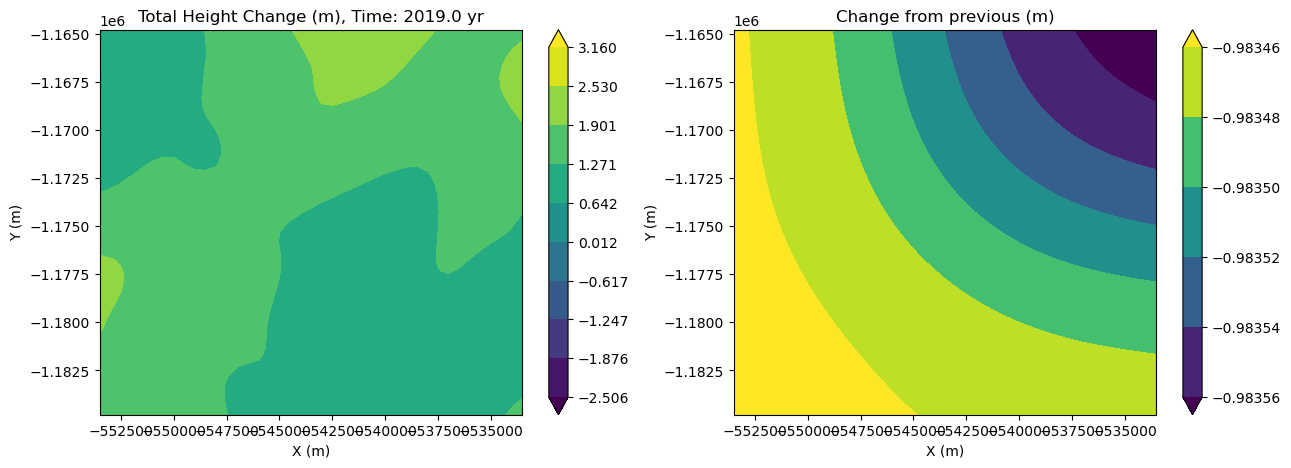

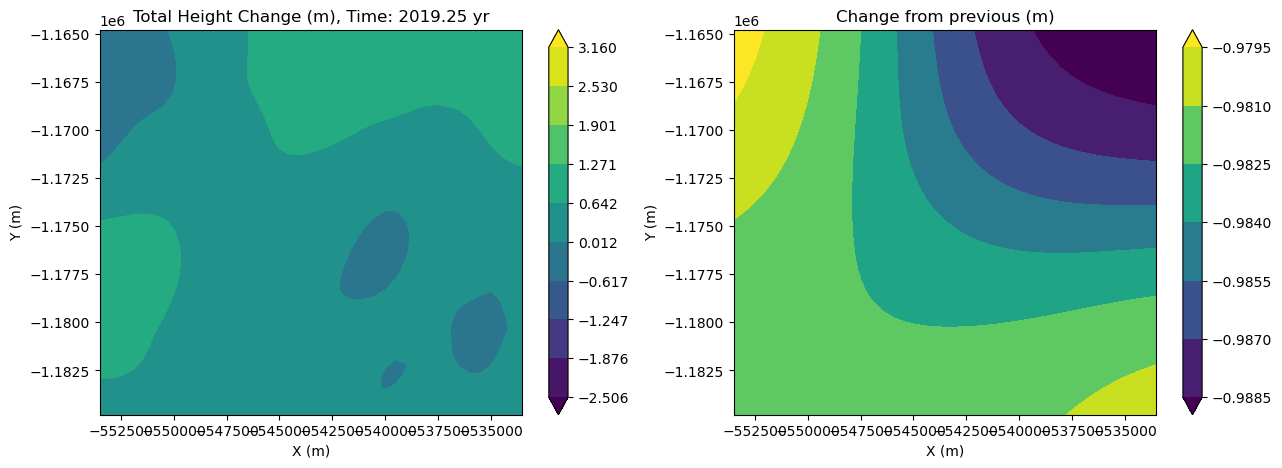

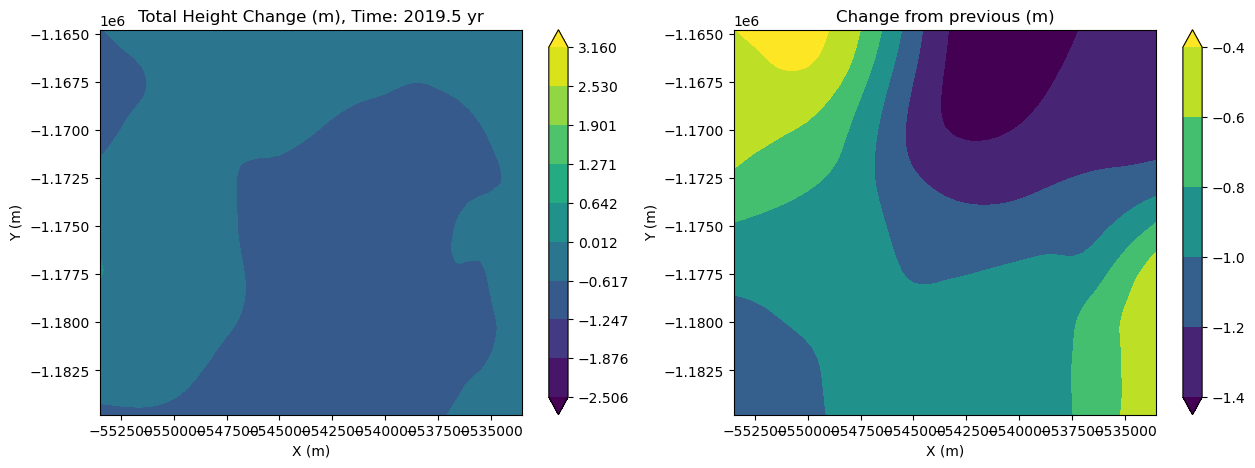

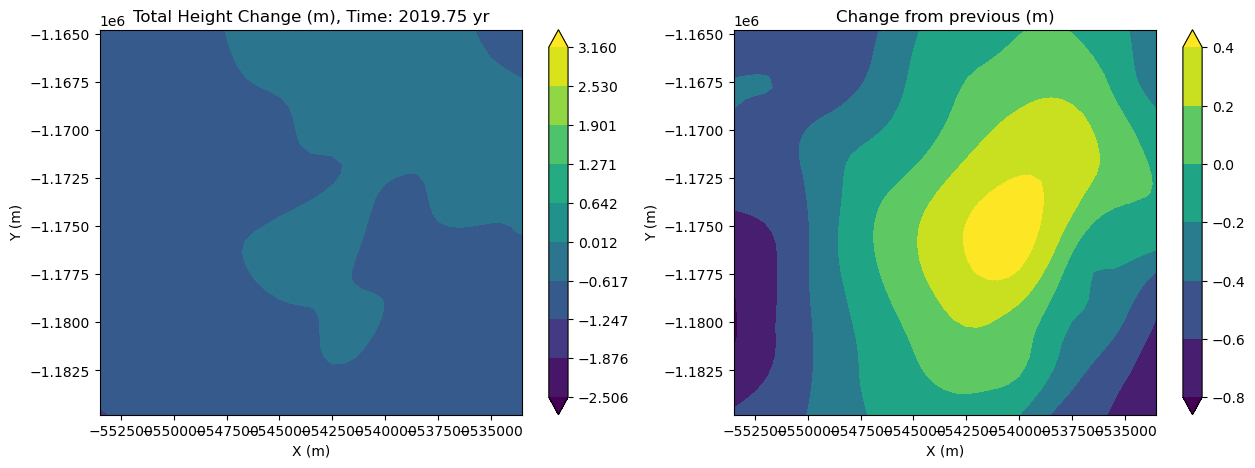

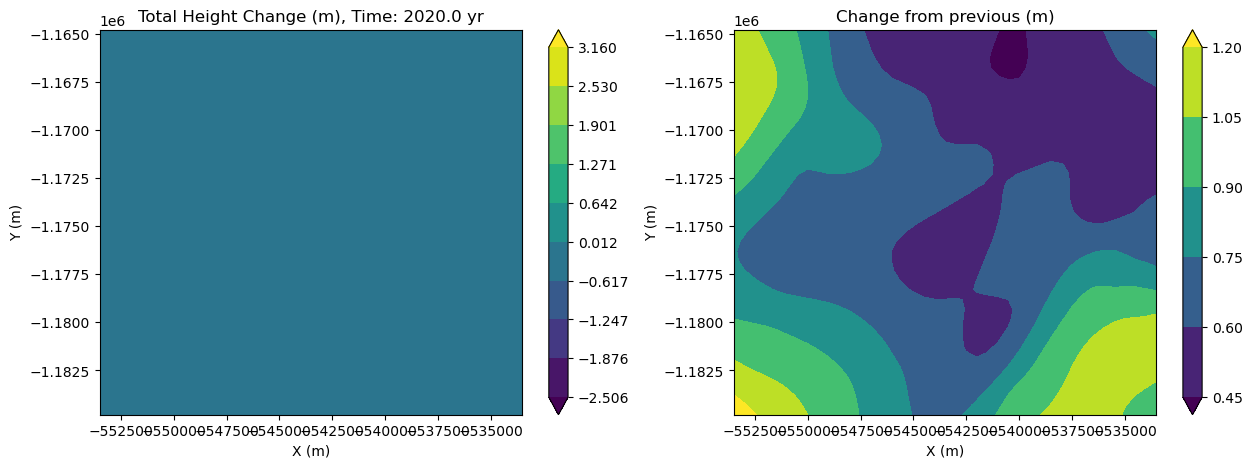

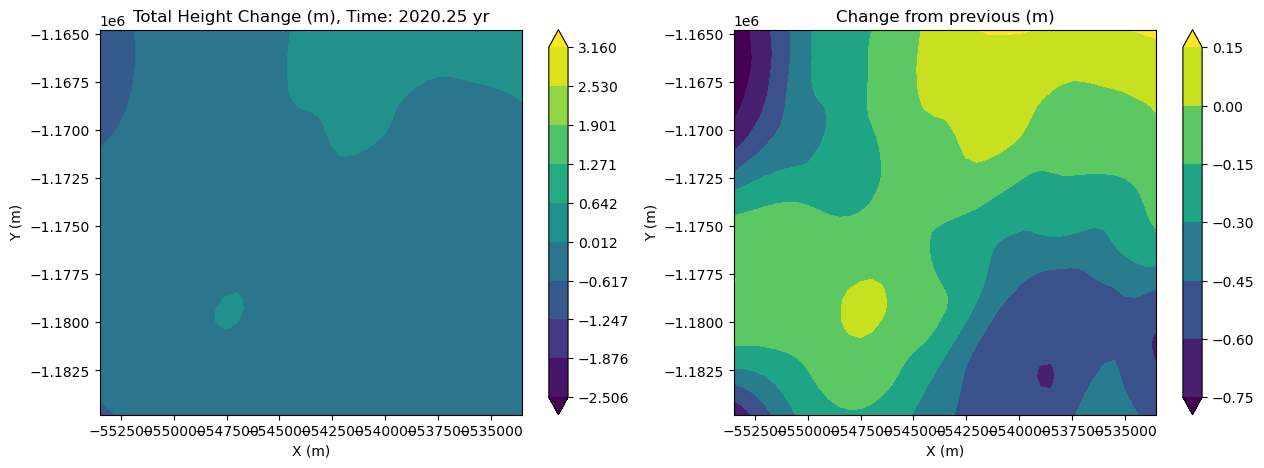

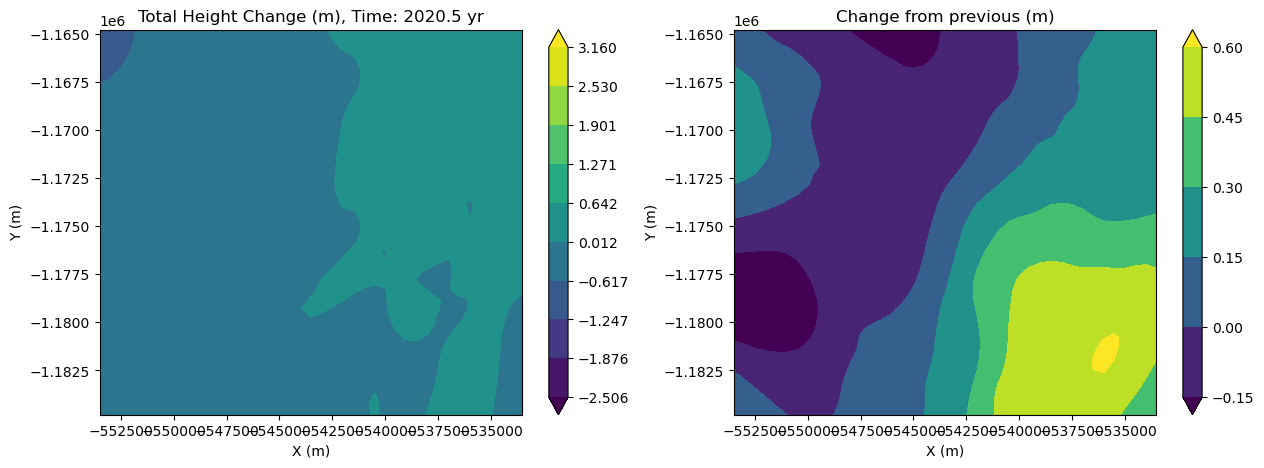

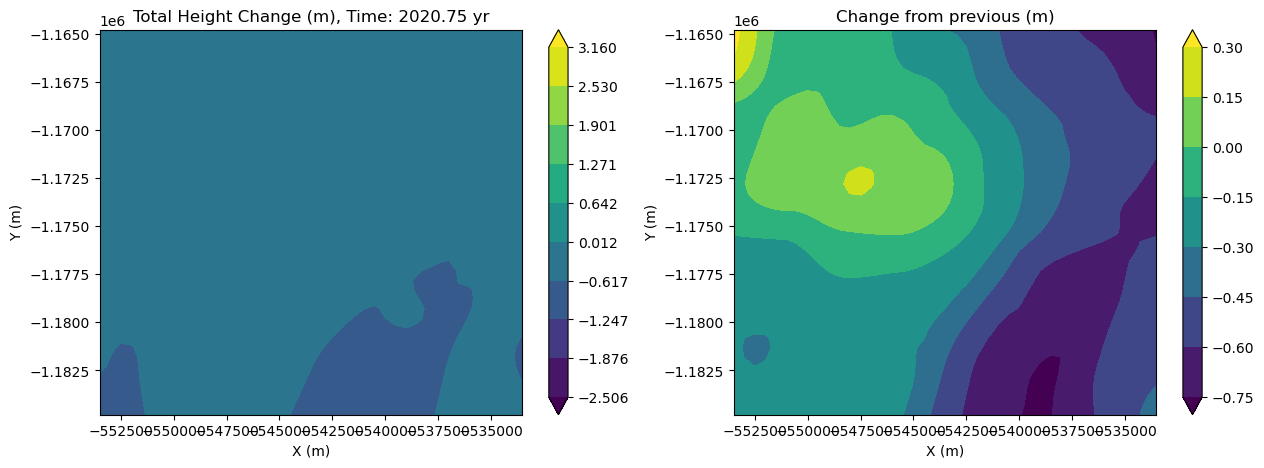

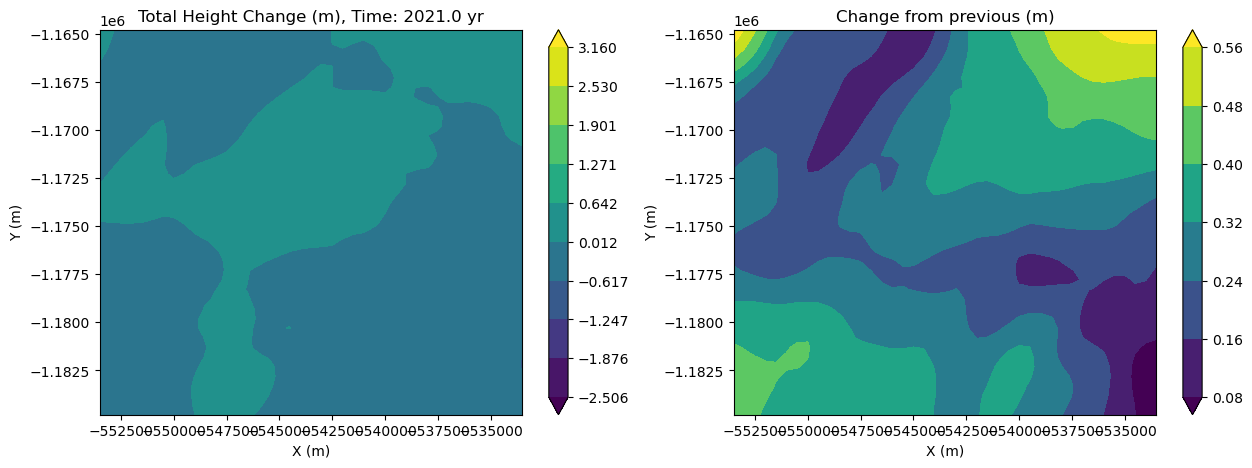

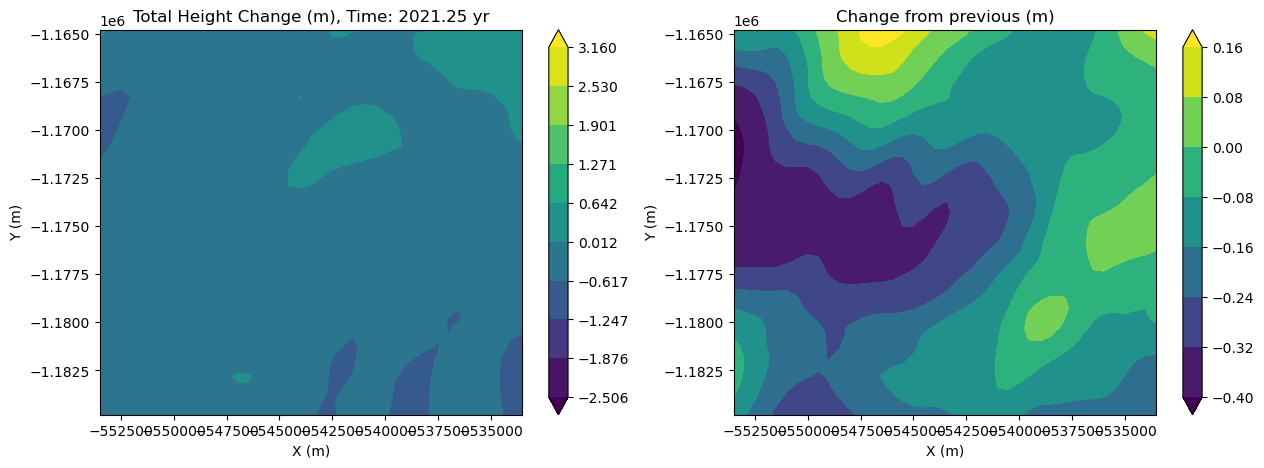

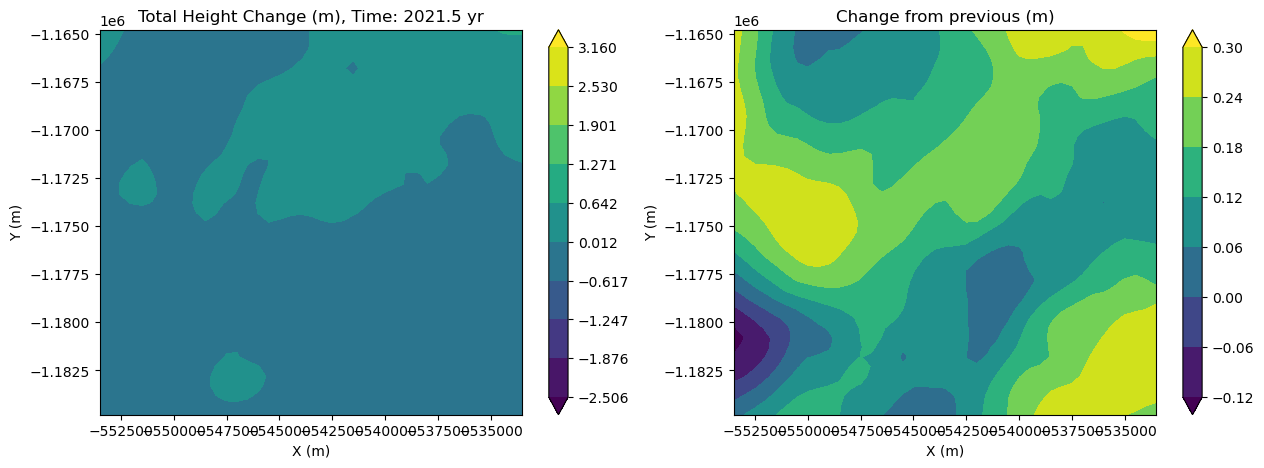

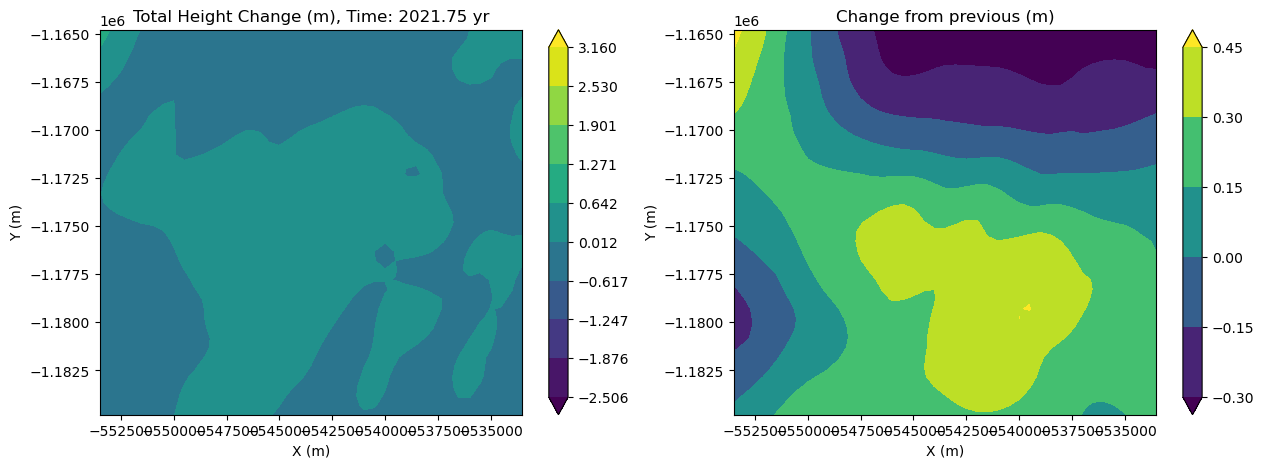

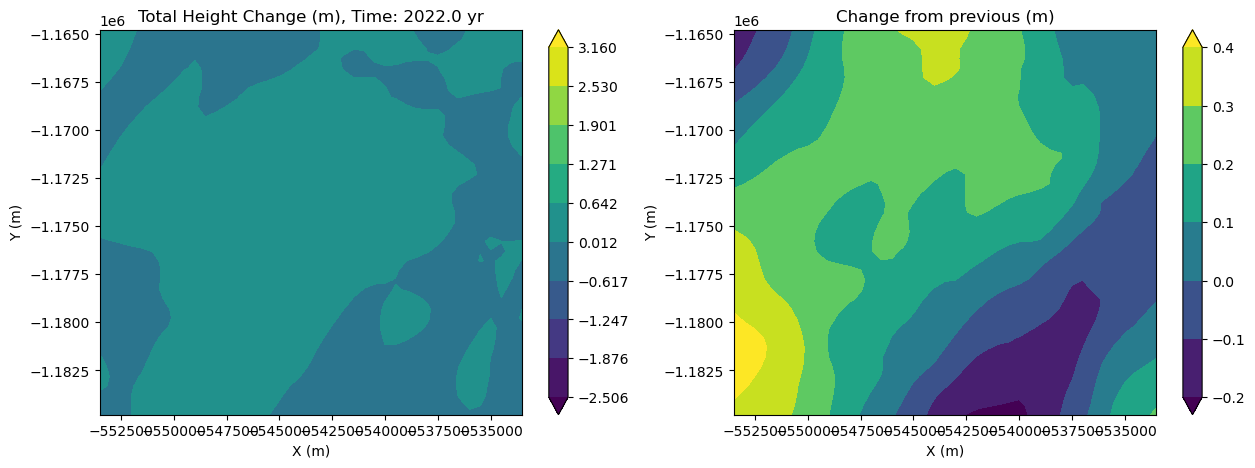

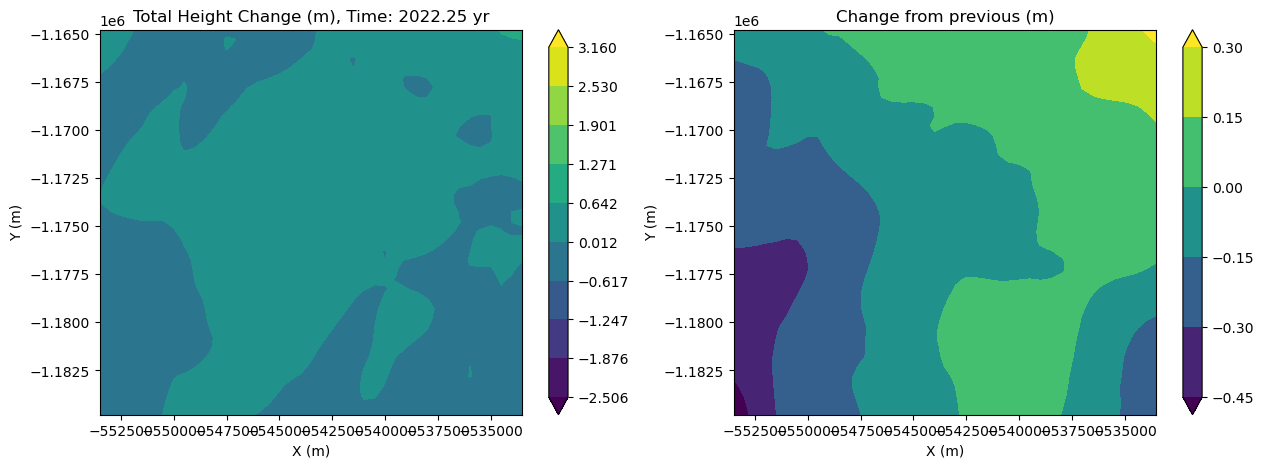

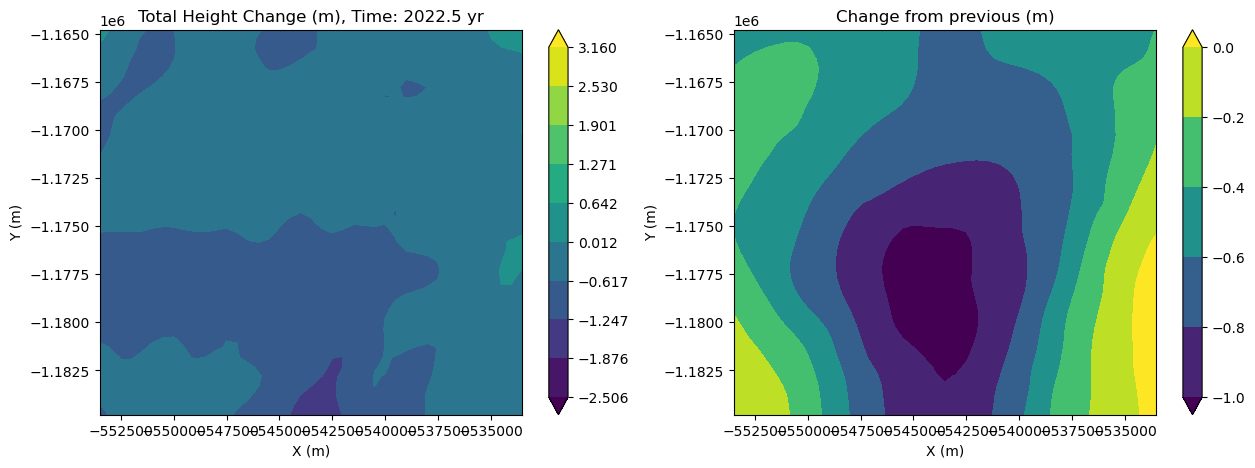

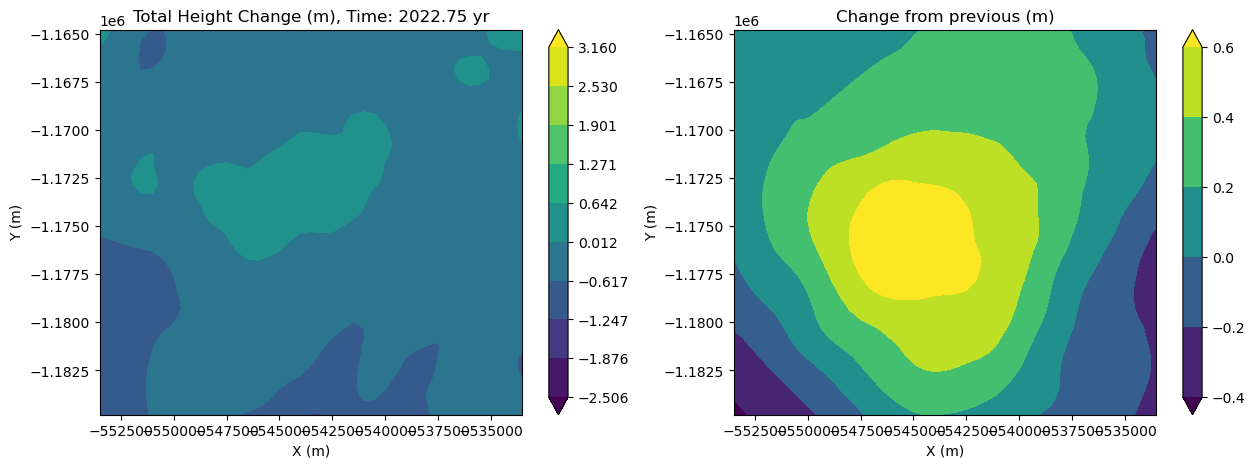

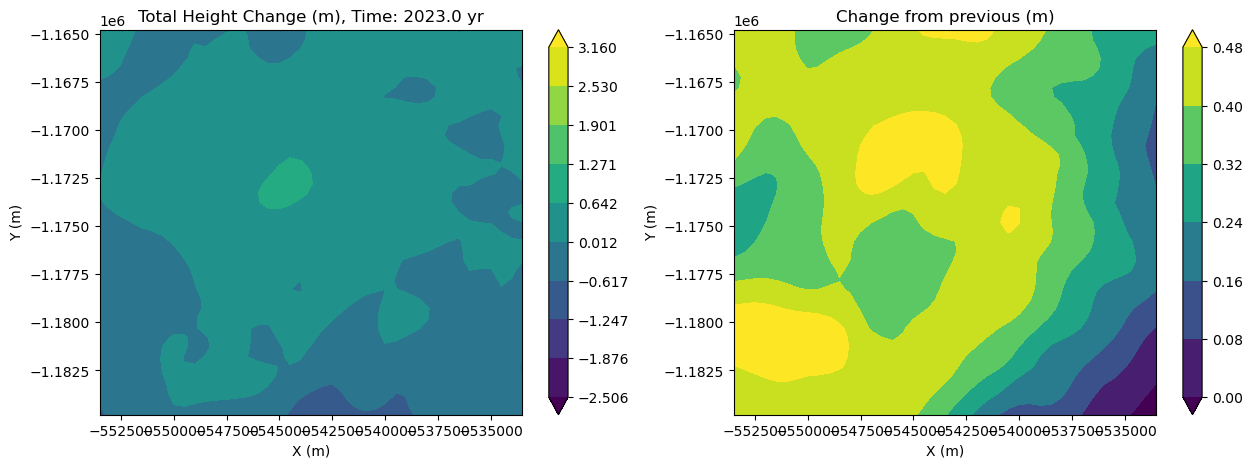

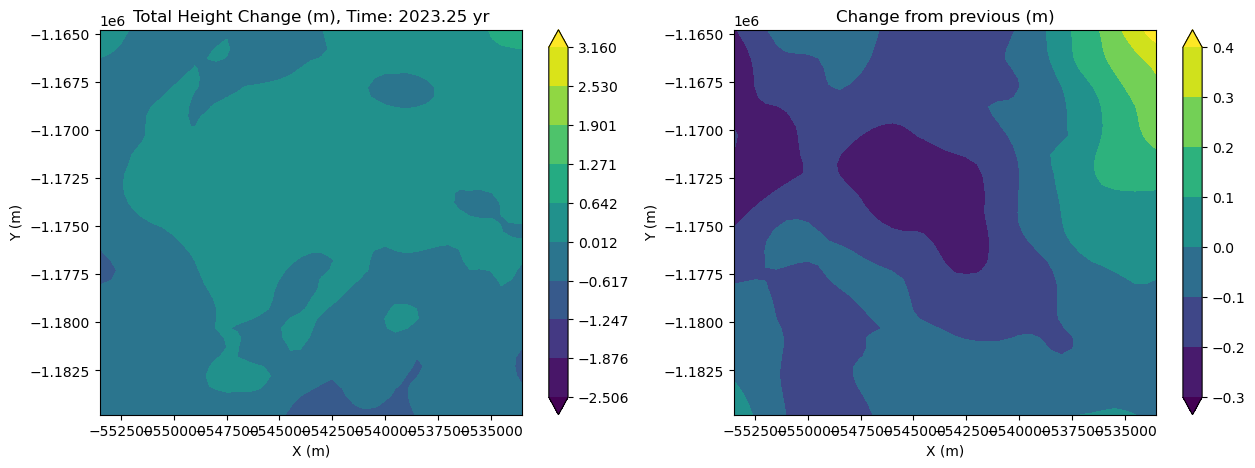

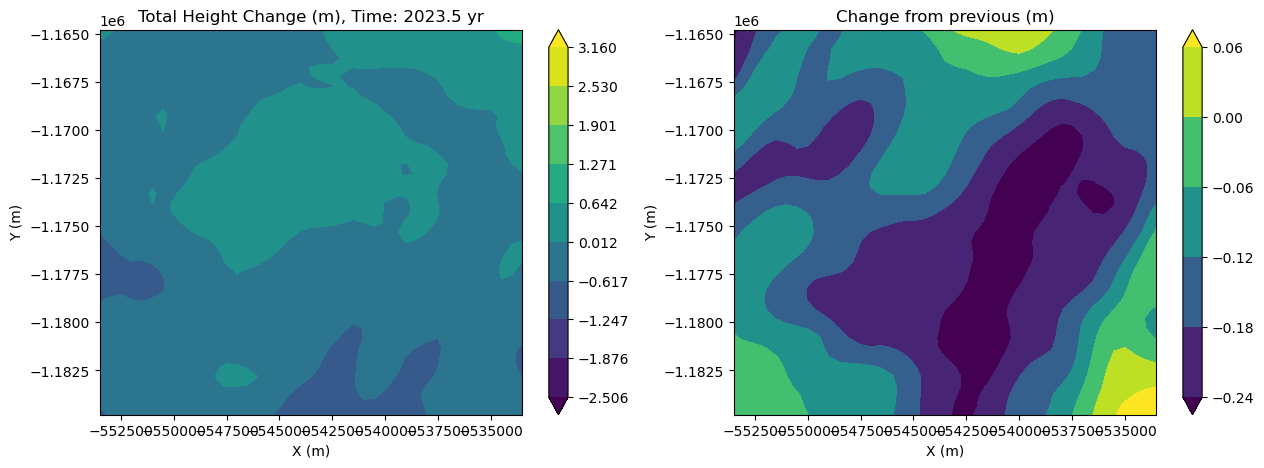

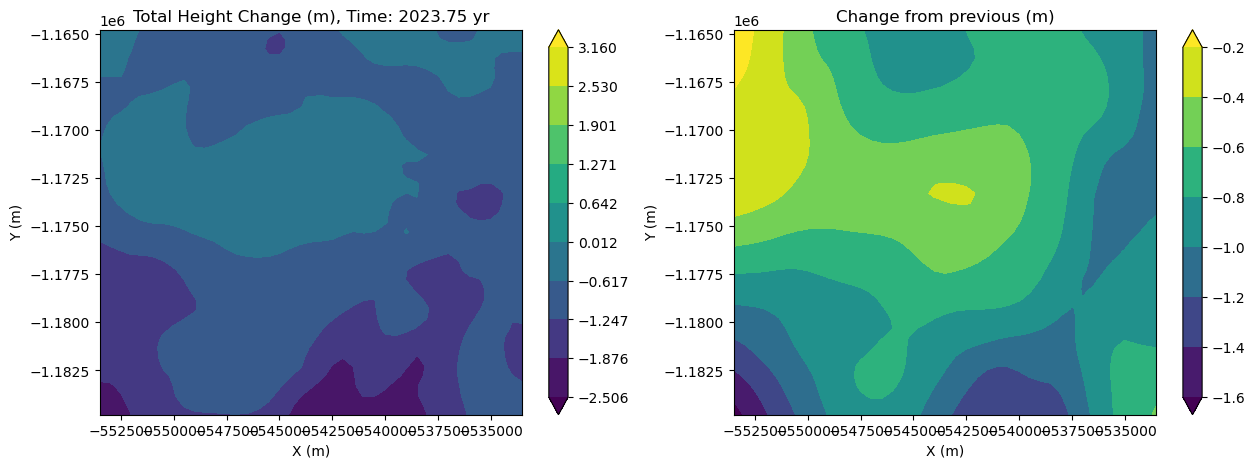

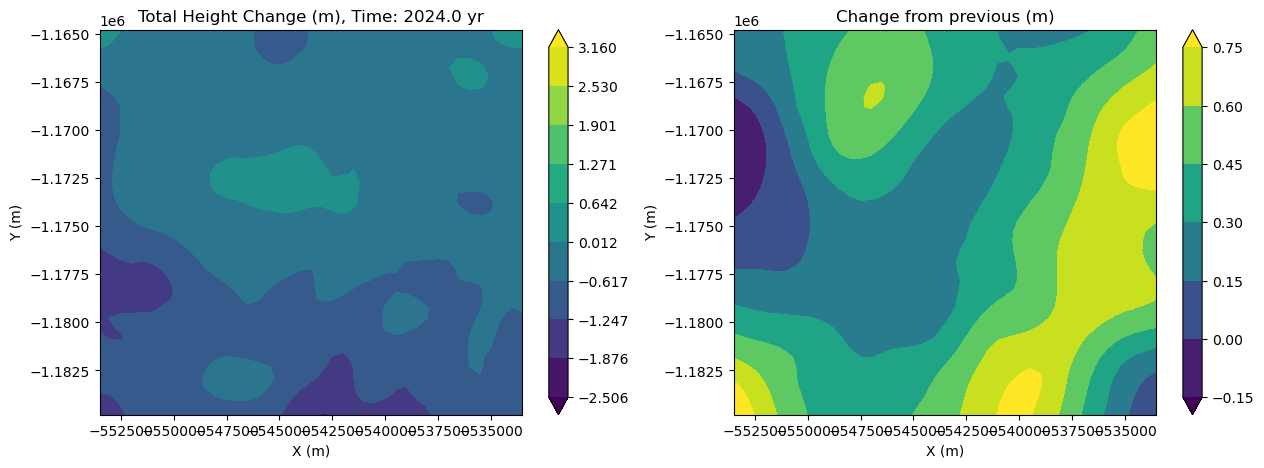

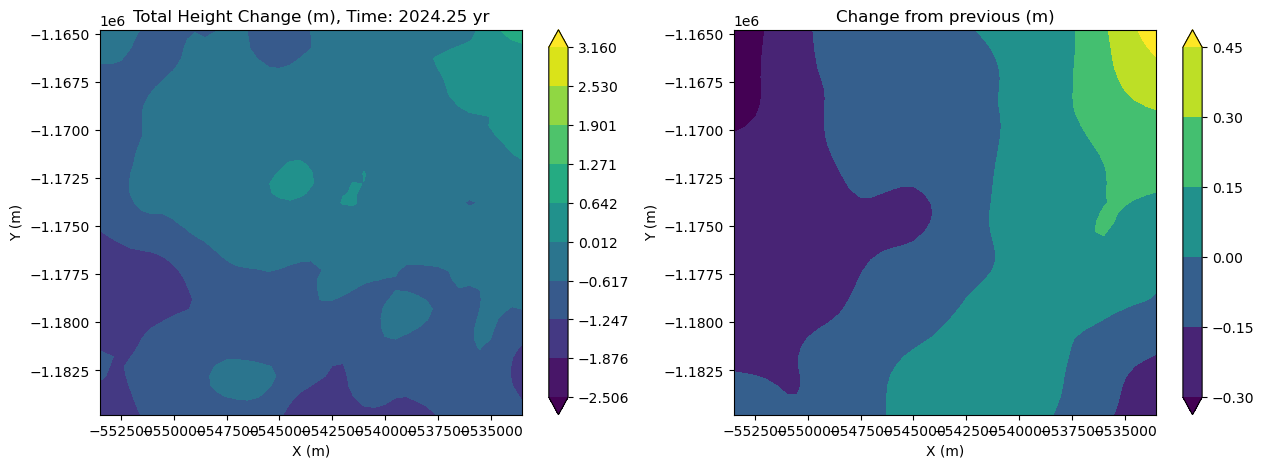

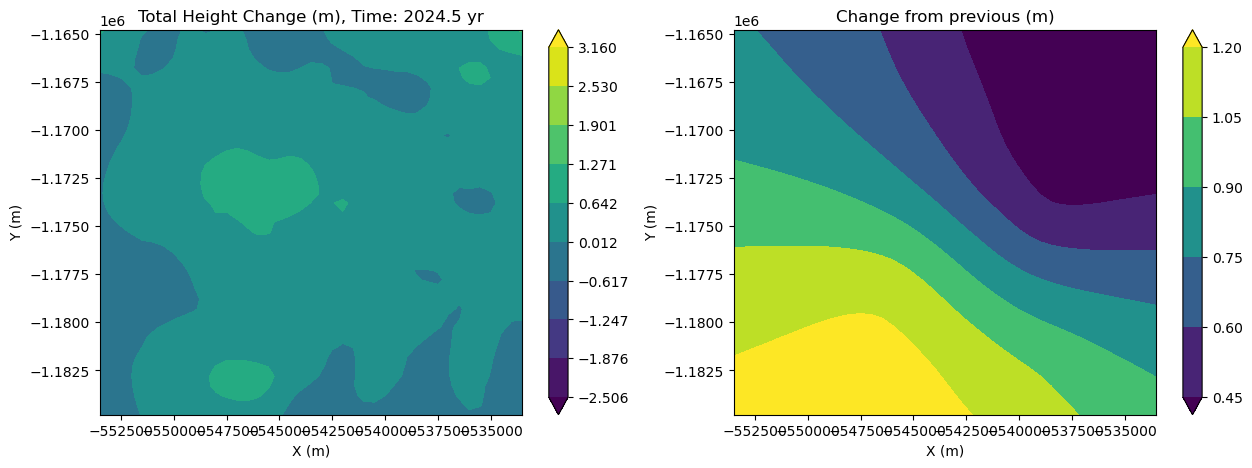

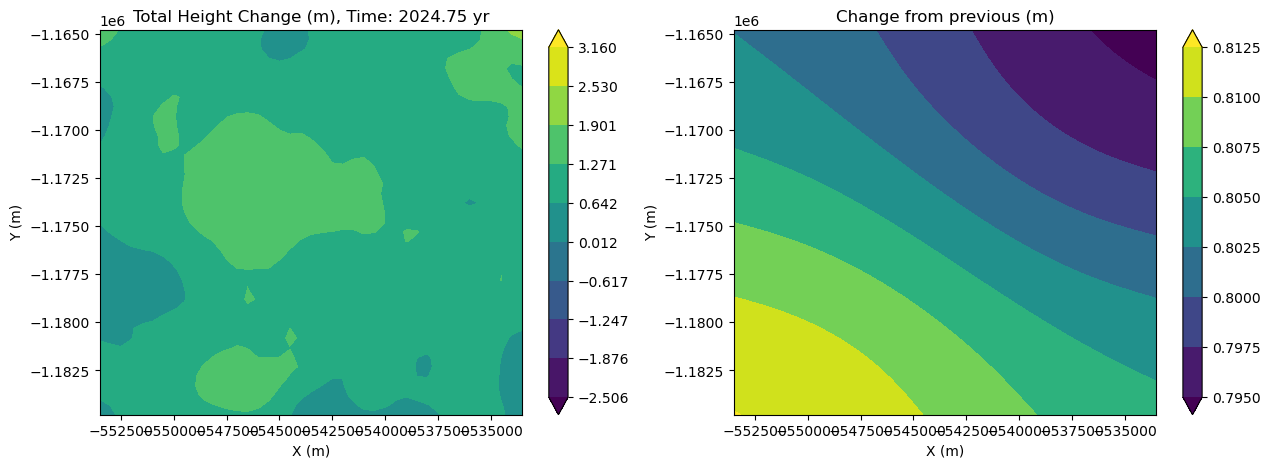

In [97]:
dzmin = np.nanmin(dz.dz)
dzmax = np.nanmax(dz.dz)
levels = np.linspace(dzmin, dzmax, 10)

for i in range(0, dz.shape[2]):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.contourf(xgd, ygd, dz.dz[:,:,i], origin='lower',levels=levels, extend='both')
    plt.colorbar()
    plt.title('Total Height Change (m), Time: {} yr'.format(dz.t[i]))
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    
    plt.subplot(1,2,2)
    if i == 0:
        plt.contourf(xgd, ygd, np.zeros_like(xgd), origin='lower', extend='both')
    else:
        plt.contourf(xgd, ygd, dz.dz[:,:,i]-dz.dz[:,:,i-1], origin='lower', extend='both')
    plt.colorbar()
    plt.title('Change from previous (m)')
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')

    plt.show()